<a href="https://colab.research.google.com/github/XMB234/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders
!pip install torch-summary

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import torch
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("preetviradiya/brian-tumor-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brian-tumor-dataset


In [4]:
data = pd.read_csv(path + '/metadata.csv')
data.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [5]:
data.shape

(4600, 6)

In [6]:
import os
import pathlib
import splitfolders

# Tentukan path ke folder dataset
data_dir = pathlib.Path(path) / "Brain Tumor Data Set" / "Brain Tumor Data Set"

# Lihat isi folder (opsional, bisa dihapus kalau tidak diperlukan)
print("Isi folder data:", os.listdir(data_dir))

# Folder hasil split
output_dir = pathlib.Path("output")

# Split dataset menjadi train (80%) dan val (20%)
splitfolders.ratio(
    input=data_dir,
    output=output_dir,
    seed=1337,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None
)

Isi folder data: ['Brain Tumor', 'Healthy']


Copying files: 4600 files [00:32, 141.18 files/s]


In [7]:
# Tampilkan path absolut folder output
print("Folder output disimpan di:", output_dir.resolve())

Folder output disimpan di: /content/output


In [15]:
from torchvision import transforms

# Transformasi data (train): resize, augmentasi, konversi tensor, normalisasi
train_transform = transforms.Compose([
    transforms.Resize(224),  # Sama dengan (224, 224), karena square
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # Rata-rata channel RGB dari ImageNet
        std=[0.229, 0.224, 0.225]     # Std dev dari ImageNet
    )
])

#  Transformasi untuk val dan test (tanpa augmentasi)
test_val_transform =transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [16]:
# Buat dataset
train_set = torchvision.datasets.ImageFolder(output_dir / "train", transform=train_transform)
val_set = torchvision.datasets.ImageFolder(output_dir / "val", transform=test_val_transform)
test_set = torchvision.datasets.ImageFolder(output_dir / "test", transform=test_val_transform)

In [17]:
print("Label/class yang dikenali:", train_set.classes)

Label/class yang dikenali: ['Brain Tumor', 'Healthy']


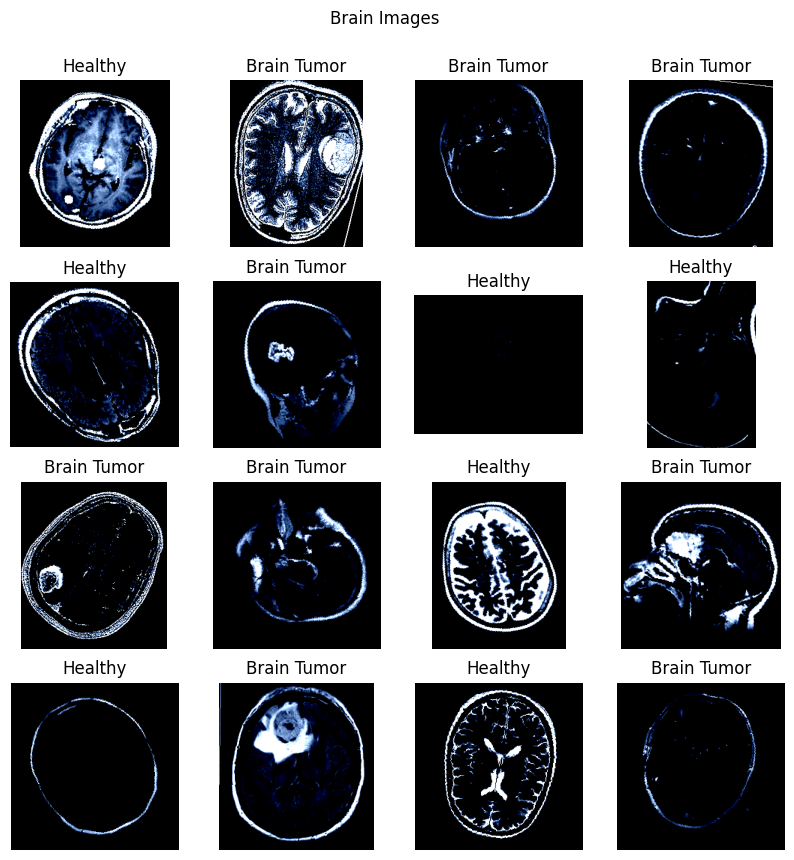

In [21]:
CLA_label = {
    0: 'Brain Tumor',
    1: 'Healthy'
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_set), size=(1,)).item()
  img, label = train_set[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(CLA_label[label])
  plt.axis("off")
  img_np = img.numpy().transpose((1, 2, 0))

  img_valid_range = np.clip(img_np, 0, 1)
  plt.imshow(img_valid_range)
  plt.suptitle('Brain Images', y=0.95)
plt.show()

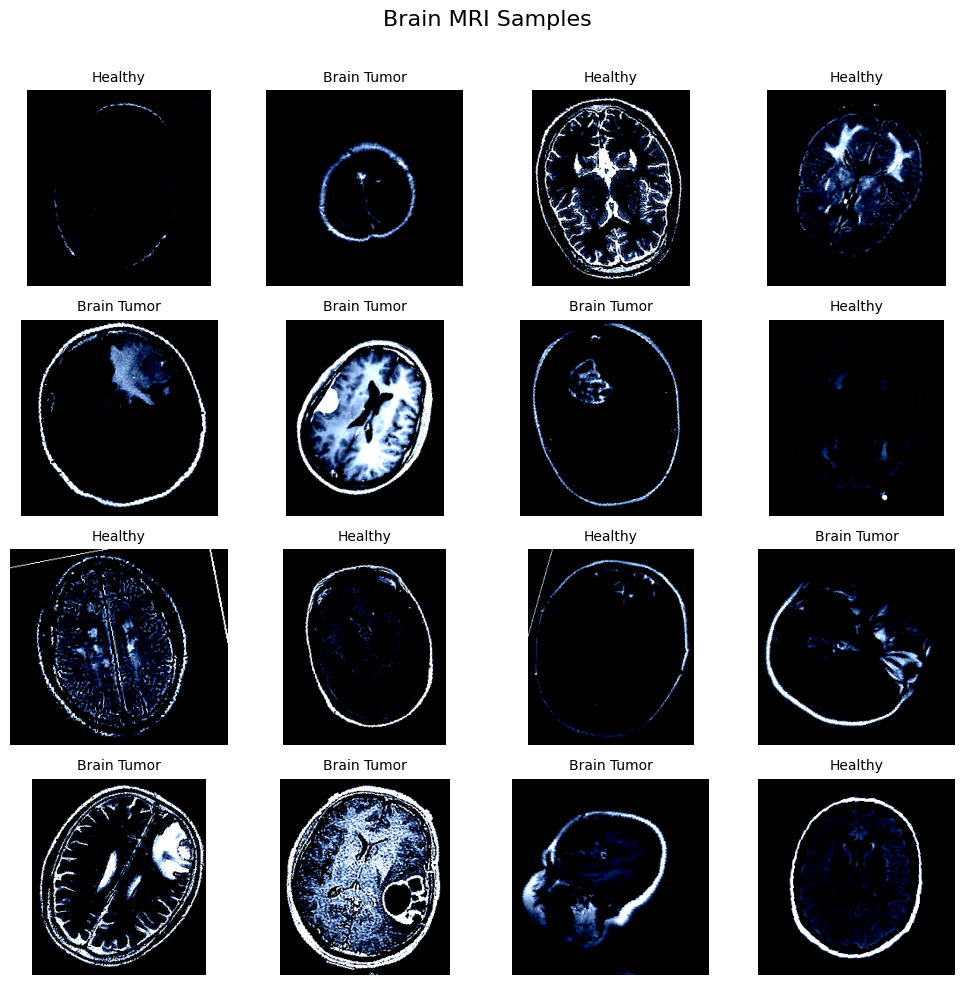

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ambil label dari train_set langsung, agar dinamis
class_labels = train_set.classes  # ['Brain Tumor', 'Healthy']

def imshow_tensor(img_tensor):
    """Convert tensor to NumPy image and handle normalization"""
    img_np = img_tensor.numpy().transpose((1, 2, 0))
    img_np = np.clip(img_np, 0, 1)  # Pastikan nilai dalam rentang valid
    return img_np

# Setup grid
cols, rows = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
fig.suptitle("Brain MRI Samples", fontsize=16)

for i in range(rows * cols):
    idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[idx]
    ax = axes[i // cols, i % cols]
    ax.imshow(imshow_tensor(img))
    ax.set_title(class_labels[label], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()